<img src="https://www.mines.edu/webcentral/wp-content/uploads/sites/267/2019/02/horizontallightbackground.jpg" width="100%"> 

### CSCI250 Python Computing: Building a Sensor System
<hr style="height:5px" width="100%" align="left">

# LAB: Recording studio 
## Jacob States

# Introduction

The goal for this lab is to collect a large volume of data from all output pins of a microphone and store them in `numpy` arrays. 

Once the recording is complete, you will perform basic data analysis, storage and visualization. 

<img src="https://www.dropbox.com/s/u628vjn2uc5h3ua/notebook.png?raw=1" width="10%" align="right">

Read through
* the [GPIO notebook](h_GPIO.ipynb) to learn about the General Purpose IO interface;
* the [ADC notebook](h_ADC.ipynb)  to learn how to measure analog voltages;
* the [microphone notebook](h_Microphone.ipynb) to learn about a device with both digital and analog outputs;
* the [flex sensor notebook](h_FlexSensor.ipynb) to learn about a device with analog output.

**Build the circuits in all notebooks to ensure that everything works correctly.**

# Pre-lab questions

### Microphone
1. How must the microphone be wired in order to use it?
    * The audio and envelope pins should be wired to the first ADC while the Gate should be sending input to the Rpi Wedge and the VCC and GND should be wired to power rails. 
2. How do the different analog outputs of the microphone represent?
    * Audio gives raw voltage from microphone biased around 1.67 V. Envelope tracks the peaks of the audio voltage its the outline of the audio voltage wave.
3. What is the meaning of the microphone "gate"?
    * Returns 1 when sound is detected, returns 0 when no audio is detected.
    
### Flex Sensor
1. How must the flex sensor be wired in order to use it?
    * Should be wired in a Voltage divider with a 10k ohm resistor.
2. Why is it necessary to use a separate ADCs for the flex sensor?
    * Each ADC only has 2 input channels in order to input the audio, envelope, and voltage of the flex sensor we need 3 inputs.
3. What is the expected flex sensor resistance range?
    * 60 kohm - 110 kohm

# Directions

Your goal for this lab capture analog data provided by a microphone, convert that to digital data, store them on the RPi in `numpy` arrays, and then perform basic data processing and visualization. You will use the flex sensor to control the start and duration of data acquisition.

* Use the flex sensor to triger on and off data collection from the microphone.
    * Start data acquisition when the flex sensor is bent.
    * Stop data acquisition when the flex sensor is straight.
    * Use a threshold resistance to define what "straight sensor" means.
    
* Collect raw data from all pins and store them in `numpy` arrays.
    * Collect data as fast as possible, do not use `time.sleep()` in your loop.
    * Use appending into the `numpy` arrays during the loop.
    * Also collect the measurement time in a separate `numpy` array.

* Plot all the raw data vs. time.
    * Overlap data on the same plot and differentiate them by color.
    * Add axis labels, title and legend.
    
* Save raw data arrays to a file using `numpy.savez()`.

* Load the data from that file into different `numpy` arrays.
    
* Calculate the mean of the audio data, and subtract that value from the audio data to remove the bias.
* For periods when the gate pin returns 0, set the audio data to 0 to remove noise during quiet time.

* Plot the modified data vs. time.
    * Overlap data on the same plot and differentiate them by color.
    * Add axis labels, title and legend.

* Apply a moving average filter and moving stdev filter to the envelope data. 
    * You may use an external module for the filters, or write your own filtering code.

* Plot the raw envelope and filtered envelope data as a function of time.
    * Overlap data on the same plot and differentiate them by color.
    * Shade the area between the $mean-stdev$ and $mean+stdev$ using `plt.fill_between()`.
    * Add axis labels, title and legend.

**Use vectorization instead of loops whenever possible.**

# Your code

No starter code is provided for this lab. Use comments throughout your code so we can understand what it does. Even if you can't figure out how to write the code for something, a comment explaining what you wanted will get partial credit.

In [3]:
# Flex sensor triggers data collection
# When stright dont collect data, when bent begin collecting data, when returned to straight stop data collection
# Need threshold to define straight and bent
import numpy as np
import adcUtil as adc
import RPi.GPIO as GPIO
import time

# Set pins for led and audio gate
GPIO.setmode(GPIO.BCM)
gatepin = 17
GPIO.setup(gatepin, GPIO.IN)
ledpin = 27
GPIO.setup(ledpin, GPIO.OUT)

# Define arrays to append to throughout the loop
Vfs = adc.readADC(channel=0, device=1)
arr_t = np.ndarray([], dtype='float', order='C')
arr_aud = np.ndarray([], dtype='float', order='C')
arr_env = np.ndarray([], dtype='float', order='C')
arr_gate = np.ndarray([], dtype='int8', order='C')
t0 = time.time()
s = True
while s:
    try:
        Vfs = adc.readADC(channel=0, device=1)
        aud = adc.readADC(channel=0, device=0)
        env = adc.readADC(channel=1, device=0)
        if Vfs > 0.8 or Vfs < 0.7: # Threshold for when to begin recording
            print('On air', Vfs)
            GPIO.output(ledpin, True) # Turns light on
            Vfs = adc.readADC(channel=0, device=1) 
            aud = adc.readADC(channel=0, device=0) # Reads audio data
            arr_aud = np.append(arr_aud, aud)      # Appends audio data
            env = adc.readADC(channel=1, device=0) # Reads envelope data
            arr_env = np.append(arr_env, env)      # Appends envelope data
            gate = GPIO.input(gatepin)             # Reads gate data
            arr_gate = np.append(arr_gate, gate)   # Appends gate data
            t = time.time()
            arr_t = np.append(arr_t, t-t0)         # Appends change in time from start of code block to iteration
            pass
        else:
            GPIO.output(ledpin, False)             # Turns led off
            Vfs = adc.readADC(channel=0, device=1)
            pass
    except KeyboardInterrupt: # This section takes out the first data point because its always ridiculous
        arr_t = arr_t[1:]
        arr_aud = arr_aud[1:]
        arr_env = arr_env[1:]
        arr_gate = arr_gate[1:]
        print('Interrupt', arr_t, arr_aud, arr_env, arr_gate)
        s = False # Big brain actually stops the loop took me way too long to figure out

On air 0.26129032258064516
On air 0.26129032258064516
On air 0.26129032258064516
On air 0.25806451612903225
On air 0.26129032258064516
On air 0.25806451612903225
On air 0.25806451612903225
On air 0.25806451612903225
On air 0.25806451612903225
On air 0.26129032258064516
On air 0.26129032258064516
On air 0.25806451612903225
On air 0.25483870967741934
On air 0.25806451612903225
On air 0.25806451612903225
On air 0.25483870967741934
On air 0.25483870967741934
On air 0.25161290322580643
On air 0.2193548387096774
On air 0.24838709677419354
On air 0.24838709677419354
On air 0.24516129032258063
On air 0.24193548387096775
On air 0.24193548387096775
On air 0.23870967741935484
On air 0.23870967741935484
On air 0.23548387096774193
On air 0.23870967741935484
On air 0.23548387096774193
On air 0.23548387096774193
On air 0.23225806451612901
On air 0.23225806451612901
On air 0.2290322580645161
On air 0.20967741935483872
On air 0.22580645161290322
On air 0.22580645161290322
On air 0.22580645161290322
On 

On air 0.5903225806451613
On air 0.5935483870967742
On air 0.5935483870967742
On air 0.5903225806451613
On air 0.5903225806451613
On air 0.5935483870967742
On air 0.5903225806451613
On air 0.5903225806451613
On air 0.5903225806451613
On air 0.5903225806451613
On air 0.5903225806451613
On air 0.5967741935483871
On air 0.5935483870967742
On air 0.5935483870967742
On air 0.5903225806451613
On air 0.5903225806451613
On air 0.5935483870967742
On air 0.5935483870967742
On air 0.5903225806451613
On air 0.5935483870967742
On air 0.5903225806451613
On air 0.5967741935483871
On air 0.5935483870967742
On air 0.5935483870967742
On air 0.5903225806451613
On air 0.6
On air 0.5935483870967742
On air 0.5935483870967742
On air 0.5935483870967742
On air 0.5903225806451613
On air 0.5903225806451613
On air 0.5903225806451613
On air 0.5967741935483871
On air 0.5903225806451613
On air 0.5935483870967742
On air 0.5935483870967742
On air 0.5935483870967742
On air 0.5870967741935484
On air 0.5903225806451613
O

On air 0.5
On air 0.47419354838709676
On air 0.5
On air 0.5
On air 0.5
On air 0.5
On air 0.5032258064516129
On air 0.5
On air 0.5
On air 0.4967741935483871
On air 0.4967741935483871
On air 0.4967741935483871
On air 0.4967741935483871
On air 0.4967741935483871
On air 0.4935483870967742
On air 0.4967741935483871
On air 0.4935483870967742
On air 0.4935483870967742
On air 0.4967741935483871
On air 0.4935483870967742
On air 0.4935483870967742
On air 0.4935483870967742
On air 0.4935483870967742
On air 0.4935483870967742
On air 0.49032258064516127
On air 0.4935483870967742
On air 0.49032258064516127
On air 0.49032258064516127
On air 0.49032258064516127
On air 0.49032258064516127
On air 0.49032258064516127
On air 0.4935483870967742
On air 0.49032258064516127
On air 0.49032258064516127
On air 0.49032258064516127
On air 0.48709677419354835
On air 0.48709677419354835
On air 0.48709677419354835
On air 0.48709677419354835
On air 0.48709677419354835
On air 0.4967741935483871
On air 0.490322580645161

On air 0.4935483870967742
On air 0.4935483870967742
On air 0.49032258064516127
On air 0.4935483870967742
On air 0.49032258064516127
On air 0.49032258064516127
On air 0.49032258064516127
On air 0.49032258064516127
On air 0.48709677419354835
On air 0.49032258064516127
On air 0.49032258064516127
On air 0.49032258064516127
On air 0.5
On air 0.48709677419354835
On air 0.48709677419354835
On air 0.4838709677419355
On air 0.48709677419354835
On air 0.48709677419354835
On air 0.4838709677419355
On air 0.48709677419354835
On air 0.48709677419354835
On air 0.48709677419354835
On air 0.48709677419354835
On air 0.48709677419354835
On air 0.4838709677419355
On air 0.4838709677419355
On air 0.4838709677419355
On air 0.4838709677419355
On air 0.4838709677419355
On air 0.4838709677419355
On air 0.4838709677419355
On air 0.4838709677419355
On air 0.4838709677419355
On air 0.4838709677419355
On air 0.4838709677419355
On air 0.4806451612903226
On air 0.4806451612903226
On air 0.4838709677419355
On air 0.

On air 0.4580645161290322
On air 0.4612903225806451
On air 0.4580645161290322
On air 0.4580645161290322
On air 0.4612903225806451
On air 0.4580645161290322
On air 0.4612903225806451
On air 0.4612903225806451
On air 0.4612903225806451
On air 0.4612903225806451
On air 0.4612903225806451
On air 0.4612903225806451
On air 0.4612903225806451
On air 0.4580645161290322
On air 0.4612903225806451
On air 0.4612903225806451
On air 0.4612903225806451
On air 0.4612903225806451
On air 0.4774193548387097
On air 0.46451612903225803
On air 0.4612903225806451
On air 0.46451612903225803
On air 0.46451612903225803
On air 0.46451612903225803
On air 0.46451612903225803
On air 0.46451612903225803
On air 0.46451612903225803
On air 0.46451612903225803
On air 0.4419354838709677
On air 0.46451612903225803
On air 0.46451612903225803
On air 0.46774193548387094
On air 0.46451612903225803
On air 0.47096774193548385
On air 0.46451612903225803
On air 0.46774193548387094
On air 0.46774193548387094
On air 0.4838709677419

On air 0.45161290322580644
On air 0.4548387096774193
On air 0.4548387096774193
On air 0.45161290322580644
On air 0.45161290322580644
On air 0.4548387096774193
On air 0.45161290322580644
On air 0.45161290322580644
On air 0.4548387096774193
On air 0.45161290322580644
On air 0.45161290322580644
On air 0.4483870967741935
On air 0.45161290322580644
On air 0.45161290322580644
On air 0.45161290322580644
On air 0.4483870967741935
On air 0.45161290322580644
On air 0.46451612903225803
On air 0.4548387096774193
On air 0.45161290322580644
On air 0.4483870967741935
On air 0.4548387096774193
On air 0.4483870967741935
On air 0.4548387096774193
On air 0.4548387096774193
On air 0.4548387096774193
On air 0.4548387096774193
On air 0.45161290322580644
On air 0.4548387096774193
On air 0.45161290322580644
On air 0.4451612903225806
On air 0.4580645161290322
On air 0.4548387096774193
On air 0.45161290322580644
On air 0.4548387096774193
On air 0.4548387096774193
On air 0.4548387096774193
On air 0.4548387096774

On air 0.4387096774193548
On air 0.43548387096774194
On air 0.4387096774193548
On air 0.4387096774193548
On air 0.4419354838709677
On air 0.4387096774193548
On air 0.4161290322580645
On air 0.4387096774193548
On air 0.4387096774193548
On air 0.4387096774193548
On air 0.4387096774193548
On air 0.4387096774193548
On air 0.4387096774193548
On air 0.4387096774193548
On air 0.4387096774193548
On air 0.43548387096774194
On air 0.4387096774193548
On air 0.4612903225806451
On air 0.41935483870967744
On air 0.4387096774193548
On air 0.4387096774193548
On air 0.4387096774193548
On air 0.4387096774193548
On air 0.4387096774193548
On air 0.4387096774193548
On air 0.4387096774193548
On air 0.43548387096774194
On air 0.43548387096774194
On air 0.4387096774193548
On air 0.43548387096774194
On air 0.4387096774193548
On air 0.4387096774193548
On air 0.43548387096774194
On air 0.4387096774193548
On air 0.4387096774193548
On air 0.432258064516129
On air 0.4387096774193548
On air 0.43548387096774194
On ai

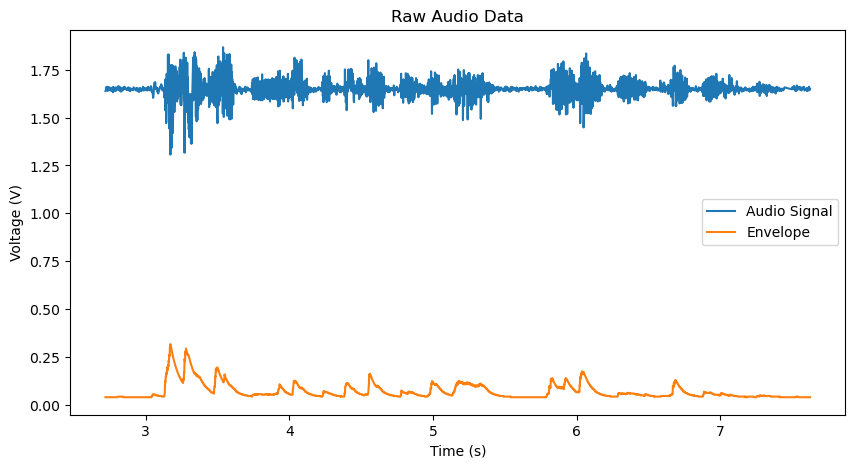

In [4]:
# Plots of Raw Data
import matplotlib.pyplot as plt

plt.figure(figsize=(10,5))
plt_aud = plt.plot(arr_t, arr_aud, label='Audio Signal')
plt_env = plt.plot(arr_t, arr_env, label='Envelope')
plt.xlabel('Time (s)')
plt.ylabel('Voltage (V)')
plt.legend()
plt.title('Raw Audio Data')
plt.show()

In [5]:
# Save Data to File
np.savez('audio_dat.npz', arr_t, arr_aud, arr_env, arr_gate)

In [6]:
# Load and Copy data
aud_dat = np.load('audio_dat.npz')
print(aud_dat.files)
arr_t_c = aud_dat['arr_0']
arr_aud_c = aud_dat['arr_1'] 
arr_env_c = aud_dat['arr_2']
arr_gate_c = aud_dat['arr_3']

['arr_0', 'arr_1', 'arr_2', 'arr_3']


In [7]:
# Transforms Audio arrays
arr_t_c = arr_t_c - arr_t_c[1] # Shifts the time recording to start at 0 s

aud_mean = np.mean(arr_aud_c) # Audio mean
arr_aud_c = arr_aud_c - aud_mean # Shifts Audio Voltage to be centered around 0
gate_mask = arr_gate_c.astype(bool) 
arr_aud_c[gate_mask] = 0 # Applies fancy index mask to set all audio when gate = 0 to 0

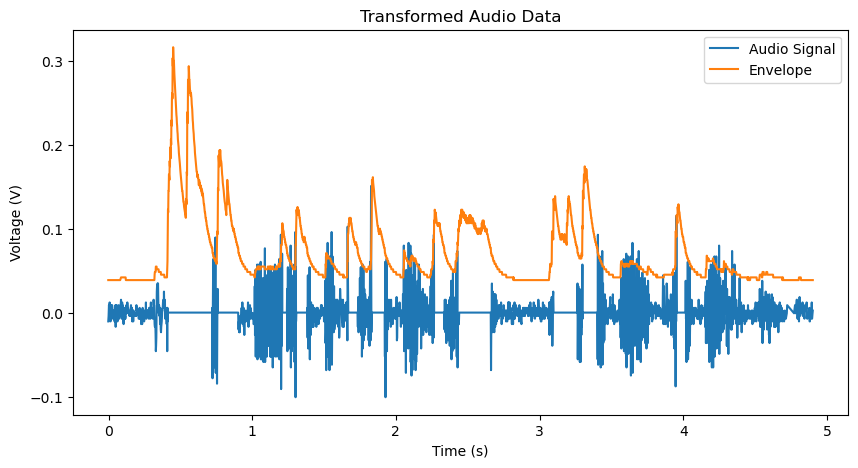

In [8]:
# Plot Transformed Data
plt.figure(figsize=(10,5))
plt_aud_c = plt.plot(arr_t_c, arr_aud_c, label='Audio Signal')
plt_env_c = plt.plot(arr_t_c, arr_env_c, label='Envelope')
plt.xlabel('Time (s)')
plt.ylabel('Voltage (V)')
plt.legend()
plt.title('Transformed Audio Data')
plt.show()

In [9]:
# Envelope Average Filter - Panic Ensues
n = 3 # window size
env_avg = np.ndarray([], dtype='float', order='C')
i = 0
while i < arr_env_c.size - n + 1:
    window = arr_env_c[i : i+n]
    avg = sum(window)/n
    env_avg = np.append(env_avg, avg)
    i+=1

In [10]:
# Attempt at stdev filter I tried to mimic the structure of the moving average but got weird values
n = 3 # window size
env_stdev = np.ndarray([], dtype='float', order='C')
i = 0
while i < arr_env_c.size - n + 1:
    window = arr_env_c[i : i+n]
    stdev = np.std(window)/n
    env_stdev = np.append(env_stdev, avg)
    i+=1

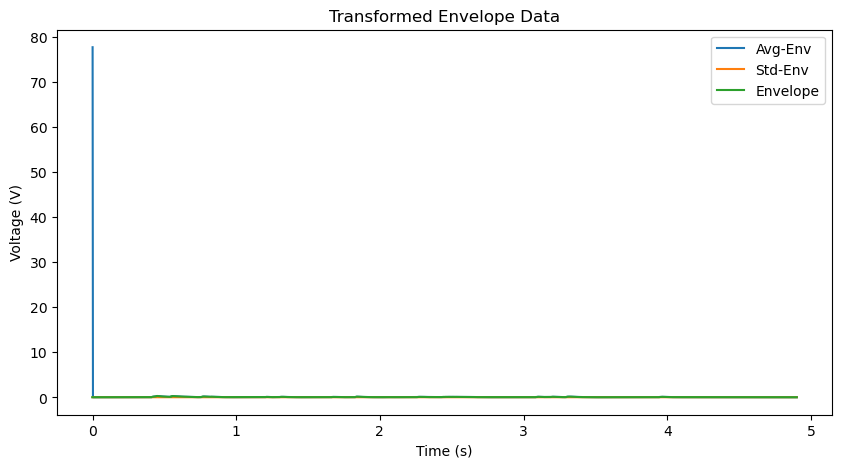

In [11]:
# Envelope Plots
plt.figure(figsize=(10,5))
plt_env_avg = plt.plot(arr_t_c[1:], env_avg, label='Avg-Env')
plt_env_std = plt.plot(arr_t_c[1:], env_stdev, label='Std-Env')
plt_env_c = plt.plot(arr_t_c, arr_env_c, label='Envelope')
plt.xlabel('Time (s)')
plt.ylabel('Voltage (V)')
plt.legend()
plt.title('Transformed Envelope Data')
plt.show()

# Post lab

<img src="http://www.dropbox.com/s/fcucolyuzdjl80k/todo.jpg?raw=1" width="10%" align="right">

Before you submit the lab, make sure everything works as you expect by restarting the kernel: select **Kernel > Restart & Run All**.

Answer the following questions.

1. What elements of this lab did you find easy/challenging?
    * The envelope filtering is a complete mystery to me.
2. What did you like/dislike about this lab?
    * Rewarding when it works but most of the time I was totally lost
3. If you did anything worthy of extra credit, tell us about it here!
    * Survived...

# Submit
* Make sure to update your name and department in the top markdown cell.

* Rename the Jupyter notebook with the following convention:
**HL?-FirstLast.ipynb** (replace ? with the lab number)

* Turn in your Jupyter notebook on Canvas. Email submissions don't count.

* Include pictures of all the circuits you made.

# Honor code
Unless explicitly specified, labs are **individual exercises**. Your submission is subject to the [**Mines Honor Code**](http://inside.mines.edu/~epoeter/_GW/CSMHonorCodeUndergradHandbook.pdf).